# Import Package And Dependencies

In [3]:
!pip install requests
!pip install --upgrade yfinance
!pip install pandas
!pip install nltk
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.55
    Uninstalling yfinance-0.2.55:
      Successfully uninstalled yfinance-0.2.55


In [4]:
import time
import random
import re
from collections import Counter

import requests
import json

import pandas as pd
import yfinance as yf

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# Load DATASET into Pandas Dataframe

In [ ]:
# https://www.kaggle.com/datasets/hkapoor/indian-financial-news-articles-20032020

In [7]:
def save_news_dataframe(file_path: str = 'Indian_FinancialNews_Updated.csv') -> None:
    """
    Saves the news DataFrame to a CSV file.

    Args:
        file_path (str): The path to the CSV file.
    """
    try:
        news_df.to_csv(file_path, index=False)
        print(f"News DataFrame saved to {file_path}")
    except Exception as e:
        print(f"Error: Failed to save news DataFrame: {e}")

In [8]:
def load_and_explore_data(file_path: str = 'IndianFinancialNews.csv') -> pd.DataFrame:
    """
    Loads the dataset and performs initial exploration.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame, or None if an error occurs.
    """
    try:
        # Load the dataset
        news_df = pd.read_csv(file_path)
        print("Data loaded successfully.")

        # Display the first 5 rows
        print("\n--- First 5 rows ---")
        print(news_df.head())

        # Display DataFrame info
        print("\n\n--- DataFrame Info ---")
        print(news_df.info())

        # Display DataFrame description
        print("\n\n--- DataFrame Description ---")
        print(news_df.describe())

        # Preprocess the data
        news_df = news_df[['Date', 'Title', 'Description']].drop_duplicates()
        news_df['Date'] = pd.to_datetime(news_df['Date'])
        news_df['Year'] = news_df['Date'].dt.year

        return news_df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File at {file_path} is empty")
        return None
    except pd.errors.ParserError as e:
        print(f"Error: Failed to parse file at {file_path}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [9]:
# Load the dataset
news_df = load_and_explore_data()

if news_df is None:
    exit()  # Stop execution if data loading fails

# news_df = news_df.iloc[:1500,:]

Data loaded successfully.

--- First 5 rows ---
   Unnamed: 0                    Date                                              Title                                        Description
0           0   May 26, 2020, Tuesday  ATMs to become virtual bank branches, accept d...  Close to 14.6 per cent (or 35,000) of the 240,...
1           1   May 26, 2020, Tuesday  IDFC First Bank seniors to forgo 65% of bonus ...  V Vaidyanathan, managing director and chief ex...
2           2    May 25, 2020, Monday  Huge scam in YES Bank for many years, says Enf...  Rana Kapoor's wife also charged with abetting ...
3           3    May 24, 2020, Sunday  Bank of Maharashtra sanctioned Rs 2,789 cr in ...  The bank said it was now gearing up to extend ...
4           4  May 23, 2020, Saturday  DCB Bank's profit before tax declines 37.6% to...  Net profit for the financial year ended March ...


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data column

# Initialize NLP Components¶

In [11]:
# Initialize sentiment intensity analyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /Users/sandy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sandy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sandy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

# Initialize spaCy model for company name extraction
nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.5 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Text Processing Operations

In [14]:
company_name_exclude = ['RBI', 'BANK', 'Reserve Bank', 'Coronavirus', 'Digital India', 
                        'India', 'India Inc', 'upi', 'cooperative', 'sitharaman', 'sme', 'payment', 'sp', 'atm',
                        'msme', 'central', 'fii', 'aig', 'ipo', 'forex', 'sbt',]

def extract_company_names(title: str) -> list:
    """
    Extracts company names from the given title using spaCy's Named Entity Recognition (NER).

    Args:
        title (str): The title of the news article.

    Returns:
        list: A list of company names found in the title.
    """
    if not title:
        return []
    try:
        doc = nlp(title)
        company_names = [ent.text for ent in doc.ents if ent.label_ == 'ORG']

        company_names = [name for name in company_names if len(name) > 2]

        global company_name_exclude
        company_name_exclude = [name.upper() for name in company_name_exclude]
        
        company_names = [name for name in company_names if name.upper() not in company_name_exclude]
        return company_names
    except Exception as e:
        print(f"Error extracting company names: {e}")
        return []

In [15]:
news_df['Company Names'] = news_df['Title'].apply(extract_company_names)

In [16]:
def clean_text(text):
    """
    Cleans the text by converting to lowercase and removing special characters and digits.

    Args:
        text (str): The text to clean.

    Returns:
        str: The cleaned text.
    """
    text = str(text)

    text = re.sub(r'[^\w\s]', '', text)
    
    text = text.lower()
    # Replace periods with underscores to keep ticker symbols as single words
    text = text.replace('.', '_')

    # Remove possessive 's
    text = text.replace("'s", '')
    
    # Remove special characters and digits, but keep underscores
    text = re.sub(r'[^a-zA-Z\s_]', '', text)
    return text

In [17]:
def analyze_sentiment(description: str) -> str:
    """
    Analyzes the sentiment of the given text using NLTK's VADER sentiment analysis.

    Args:
        description (str): The text to analyze.

    Returns:
        str: The sentiment label ('Positive', 'Negative', or 'Neutral').
    """
    if not description:
        return 'Unknown'
    try:
        cleaned_description = clean_text(description)
        sentiment_scores = sia.polarity_scores(cleaned_description)
        compound_score = sentiment_scores['compound']

        if compound_score >= 0.05:
            return 'Positive'
        elif compound_score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return 'Unknown'

In [18]:
news_df['Sentiment'] = news_df['Description'].apply(analyze_sentiment)

In [19]:
def list_to_set(row):
    """Converts the list in the 'hello' column to a set."""
    if isinstance(row['Company Names'], list): # Check if the value is a list
        return list(set(row['Company Names'])) # convert to set, then back to list.
    else:
        return row['Company Names'] # Return the value if it's not a list

In [20]:
# Remove data which doesnt have company name
news_df = news_df[news_df['Company Names'].map(len) > 0]

# Text CLeaning: Eg SBI's => SBI
news_df['Company Names'] = news_df['Company Names'].apply(lambda x: [name.replace("'s", "") for name in x])

# To avoid duplicate company name, converting list to set
all_company_names = []
for sublist in news_df['Company Names'].tolist():
    all_company_names.extend(sublist)

unique_company_names = list(set(all_company_names))

#If you want to place the unique list back into the dataframe.
news_df['Company Names'] = news_df.apply(list_to_set, axis=1)

In [21]:
# Display DataFrame info
print("\n\n--- DataFrame Info ---")
print(news_df.info())

# Display DataFrame description
print("\n\n--- DataFrame Description ---")
print(news_df.describe())

# Save dataframe to csv for verifying processed data
save_news_dataframe



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 22025 entries, 1 to 49994
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           22025 non-null  datetime64[ns]
 1   Title          22025 non-null  object        
 2   Description    21653 non-null  object        
 3   Year           22025 non-null  int32         
 4   Company Names  22025 non-null  object        
 5   Sentiment      22025 non-null  object        
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 1.1+ MB
None


--- DataFrame Description ---
                                Date          Year
count                          22025  22025.000000
mean   2011-07-26 06:26:47.373439232   2011.072463
min              2003-02-11 00:00:00   2003.000000
25%              2008-01-15 00:00:00   2008.000000
50%              2011-02-15 00:00:00   2011.000000
75%              2015-05-22 00:00:00   2015.000000
m

<function __main__.save_news_dataframe(file_path: str = 'Indian_FinancialNews_Updated.csv') -> None>

# Load /Save Company Data Into Json

In [23]:
def load_company_search_history(file_path: str = 'company_date.json') -> dict:
    try:
        with open(file_path, 'r') as json_file:
            return json.load(json_file)
    except Exception as e:
        print(f"Error: Failed to load company search history: {e}")
        return {}

In [24]:
def save_company_search_history(file_path: str = 'company_date.json') -> None:
    """
    Saves the company search history to a JSON file.

    Args:
        file_path (str): The path to the JSON file.
    """
    try:
        with open(file_path, 'w') as json_file:
            json.dump(company_search_history, json_file, indent=4)
        print(f"Company search history saved to {file_path}")
    except Exception as e:
        print(f"Error: Failed to save company search history: {e}")

In [25]:
company_search_history = load_company_search_history()

# Function to Call Yahoo Api to Verify Company Name

In [27]:
def generate_random_user_agent() -> str:
    """
    Generates a random User-Agent string.

    Returns:
        str: A random User-Agent string.
    """

    # Common OS and browser combinations. Expand this list as needed.
    os_list = [
        ("Windows NT 10.0; Win64; x64", "Windows"),
        ("Macintosh; Intel Mac OS X 10_15_7", "Mac"),
        ("X11; Linux x86_64", "Linux"),
        ("X11; Ubuntu; Linux x86_64", "Ubuntu"),
        ("X11; CrOS x86_64 14541.0.0", "ChromeOS"),
        ("iPhone; CPU iPhone OS 16_0 like Mac OS X", "iOS"),
        ("Android 10; Mobile", "Android"),
    ]

    browser_list = [
        ("Chrome", "Chrome/{major_version}.{minor_version}.{build_version}.{patch_version} Safari/537.36"),
        ("Firefox", "Firefox/{major_version}.{minor_version}"),
        ("Safari", "Version/{major_version}.0 Safari/605.1.15"),
        ("Edge", "Edg/{major_version}.{minor_version}.{build_version}.{patch_version}"),
        ("Opera", "Opera/{major_version}.0 (Windows NT 10.0; Win64; x64) Presto/2.12.388 Version/12.16"),
    ]

    os_info = random.choice(os_list)
    browser_info = random.choice(browser_list)

    os_string = os_info[0]
    browser_name = browser_info[0]
    browser_version_template = browser_info[1]

    # Generate random version numbers.
    major_version = random.randint(70, 115)  # Adjust range as needed
    minor_version = random.randint(0, 9999)
    build_version = random.randint(0, 9999)
    patch_version = random.randint(0, 999)

    # Format the browser version string
    if browser_name == "Safari":
        safari_major = random.randint(10, 16)
        browser_version = browser_version_template.format(major_version=safari_major)
    elif browser_name == "Opera":
        browser_version = browser_version_template.format(major_version=major_version)
    else:
        browser_version = browser_version_template.format(
            major_version=major_version,
            minor_version=minor_version,
            build_version=build_version,
            patch_version=patch_version
        )

    user_agent = f"Mozilla/5.0 ({os_string}) AppleWebKit/537.36 (KHTML, like Gecko) {browser_version}"

    return user_agent

In [28]:
# Api Count used to logging purpose to undertand how many times yahoo finance api is called
api_count = 0


def get_ticker(company_name: str) -> str:
    """
    Retrieves the ticker symbol for a given company name.

    Args:
        company_name (str): The name of the company.

    Returns:
        str: The ticker symbol for the company, or an empty string if not found.
    """
    try:
        # Check if the company name is already in the search history
        if company_name in company_search_history:
            return company_search_history[company_name]

        # Set up the API request
        yfinance_url = "https://query2.finance.yahoo.com/v1/finance/search"
        user_agent = generate_random_user_agent()
        params = {
            "q": company_name,
            "quotes_count": 1,
            "country": "India"
        }

        print(f"Searching for: {params}")

        # Send the API request
        response = requests.get(url=yfinance_url, params=params, headers={"User-Agent": user_agent})

        # Check if the response was successful
        if response.status_code != 200:
            print(f"Failed to retrieve data: {response.status_code}")
            time.sleep(10)  # Wait 10 seconds before retrying
            return get_ticker(company_name)  # Retry the request

        # Parse the response data
        data = response.json()

        # Increment the API count
        global api_count
        api_count += 1

        # Add a delay to avoid overwhelming the API, and timeout error from api
        time.sleep(2)

        # Check if the company was found
        if data["quotes"]:
            company_code = data["quotes"][0]["symbol"]
            company_search_history[company_name] = company_code
            return company_code
        else:
            company_search_history[company_name] = ""
            return ""
            
    except Exception as e:
        print(f"An exception occurred: {e}")
        time.sleep(10)  # Wait 10 seconds before retrying
        return get_ticker(company_name)  # Retry the request

In [29]:
def process_dataframe(news_df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the 'Company Names' column of a DataFrame to extract tickers.

    Args:
        news_df (pd.DataFrame): The DataFrame containing company names.

    Returns:
        pd.DataFrame: The DataFrame with an added 'Tickers' column.
    """

    def get_tickers_for_row(company_names_list):
        """
        Helper function to get tickers for a list of company names.
        """
        if isinstance(company_names_list, list):
            tickers = [get_ticker(name) for name in company_names_list if name]  # Ignore empty strings
            return tickers
        elif isinstance(company_names_list, str):  # Handle single company name as string
            return [get_ticker(company_names_list)]
        else:
            return []  # Return empty list if the cell is not a list or string

    news_df['Tickers'] = news_df['Company Names'].apply(get_tickers_for_row)
    return news_df

In [30]:
api_count = 0
news_df = process_dataframe(news_df)

In [31]:
# Save Comapny Data Into Json for next time use, so api not needed to be called multiple times
save_company_search_history()

Company search history saved to company_date.json


# Finding Company which is mostly coming up in News using World Cloud

In [33]:
def generate_word_cloud(company_names_series, output_file='wordcloud_tickers.png'):
    """
    Generates a word cloud from a series of company names.

    Args:
        company_names_series (pd.Series): A pandas Series containing lists of company names.
        output_file (str): The name of the file to save the word cloud to.
    """
    # Convert lists of company names to a single string
    company_names = company_names_series.apply(lambda x: ' '.join([str(item) for item in x if item is not None])).str.cat(sep=' ')
    
    # Clean the text
    company_names = clean_text(company_names)
    
    # Tokenize company names
    tokens = word_tokenize(company_names)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a string
    company_names = ' '.join(tokens)

    print(type(tokens))

    # Create a word cloud
    wordcloud = WordCloud(
        width=1000,  
        height=500,  
        max_font_size=120,
        max_words=100,
        background_color='white',
        colormap='viridis'
    ).generate(company_names)

    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    plt.close()

    # Save the word cloud to a file
    wordcloud.to_file(output_file)
    print(f"\nWord cloud saved to {output_file}")

    # # Print the top words in the word cloud
    # print("Top words in the word cloud:")
    # for word, frequency in wordcloud.words_.items():
    #     print(f"{word}: {frequency}")

<class 'list'>


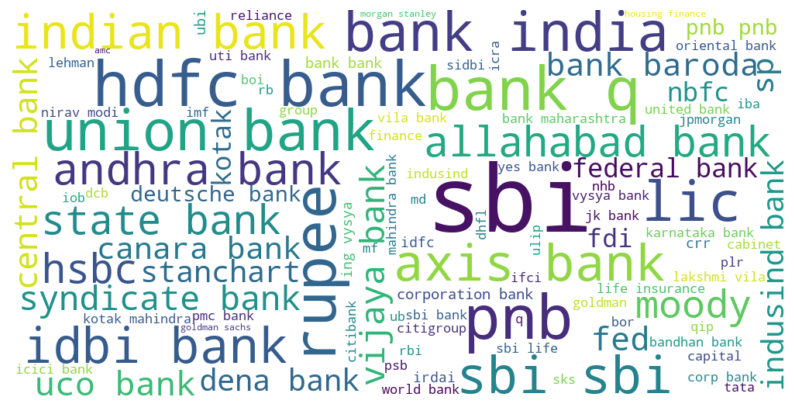


Word cloud saved to wordcloud_tickers.png


In [34]:
# Generate and save the word cloud
news_df = news_df[news_df['Tickers'].map(len) > 0]
generate_word_cloud(news_df['Company Names'])

# Year wise Sentiment Analysis Visualization

In [36]:
def analyze_and_visualize_sentiment_by_year(news_df):
    """
    Analyzes sentiment trends over time (by year) and visualizes the results
    using a line plot, a grouped bar chart, and a stacked bar chart.

    Args:
        news_df (pandas.DataFrame): The DataFrame containing news data.
    """
    # Convert the Date column to datetime
    news_df['Date'] = pd.to_datetime(news_df['Date'])

    # Extract the year and month from the Date column
    news_df['Year'] = news_df['Date'].dt.year
    news_df['Month'] = news_df['Date'].dt.month

    # Group the data by year and month, and count the number of negative, neutral, and positive sentiments
    df_grouped = news_df.groupby(['Year', 'Month', 'Sentiment']).size().reset_index(name='Count')

    # Pivot the data to create a table with year and month on the x-axis, and sentiment counts as values
    df_pivot = df_grouped.pivot_table(index=['Year', 'Month'], columns='Sentiment', values='Count').fillna(0)

    # --- Plotting ---
    # Line Chart
    df_pivot_yearly = news_df.groupby('Year')['Sentiment'].value_counts().unstack().fillna(0)
    plt.figure(figsize=(12, 6))
    df_pivot_yearly.plot(kind='bar', figsize=(15, 7), color=['#F44336', '#2196F3', '#4CAF50'])
    plt.xlabel('Year')
    plt.ylabel('News')
    plt.title(f'Sentiment Analysis: {len(news_df.index)} News Articles ({news_df['Year'].min()}-{news_df['Year'].max()})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('sentiment_trends_grouped.png')
    plt.show()

    

<Figure size 1200x600 with 0 Axes>

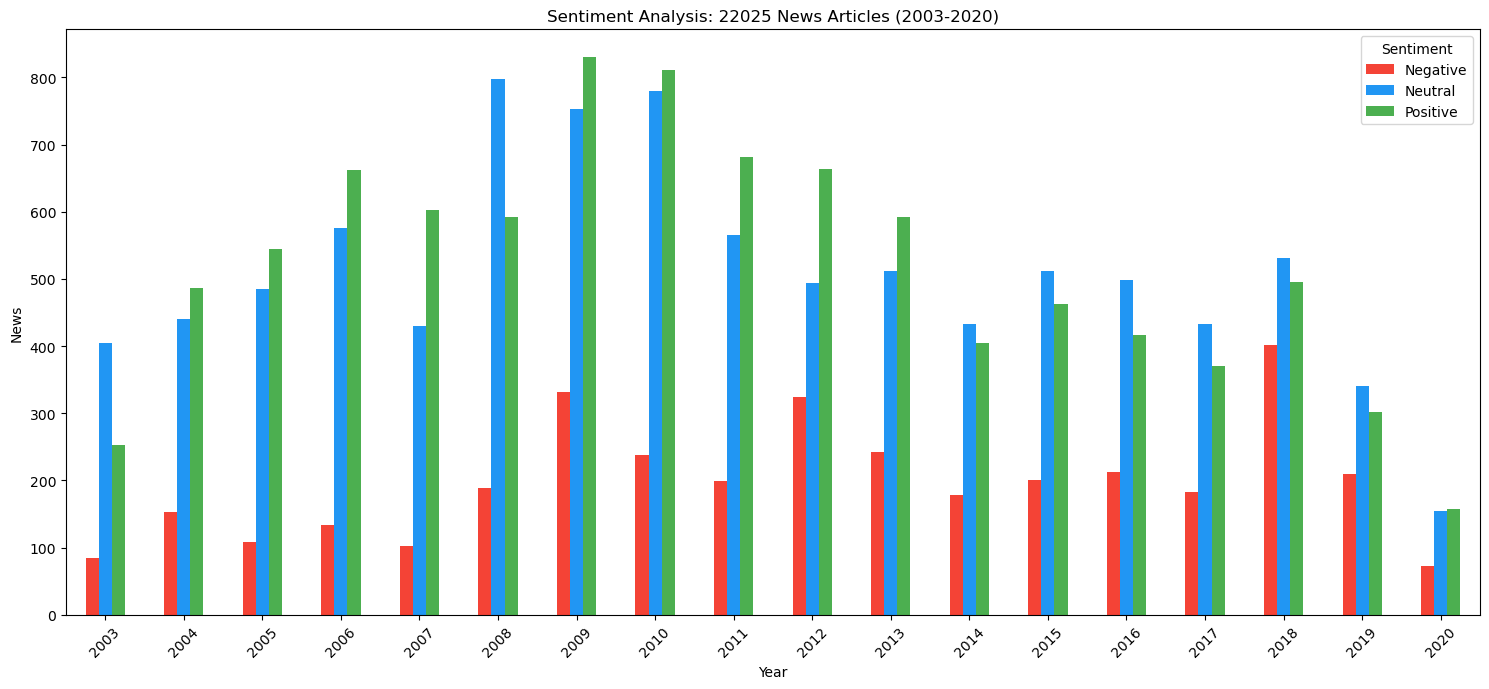

In [37]:
analyze_and_visualize_sentiment_by_year(news_df)

# Company Specific Sentiment Analysis

In [39]:
def analyze_and_visualize_company_sentiment(company_name, news_df):
    """
    Filters the dataset for a specific company, analyzes sentiment, and visualizes
    the results using a pie chart, a bar chart, and a line chart.

    Args:
        company_name (str): The name of the company to analyze.
        news_df (pandas.DataFrame): The DataFrame containing news data.
    """
    # Select a specific company
    # Filter the dataset for the specific company
    company_df = news_df[news_df['Company Names'].apply(lambda x: company_name in str(x))].copy()

    # Count the number of positive, negative, and neutral sentiments for the company
    sentiment_counts = company_df['Sentiment'].value_counts()
    positive_count = sentiment_counts.get('Positive', 0)
    negative_count = sentiment_counts.get('Negative', 0)
    neutral_count = sentiment_counts.get('Neutral', 0)

    # Print the counts
    print(f"\n--- Sentiment Counts for {company_name} ---")
    print(f"Positive Sentiments for {company_name}: {positive_count}")
    print(f"Negative Sentiments for {company_name}: {negative_count}")
    print(f"Neutral Sentiments for {company_name}: {neutral_count}")

    # Create a line chart
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    company_df['Year'] = company_df['Date'].dt.year
    company_df['Month'] = company_df['Date'].dt.month
    sentiment_counts_over_time = company_df.groupby(['Year', 'Month', 'Sentiment']).size().reset_index(name='Count')
    sentiment_counts_over_time = sentiment_counts_over_time.pivot_table(index=['Year', 'Month'], columns='Sentiment', values='Count').fillna(0)

    # Convert year to integer
    years = sentiment_counts_over_time.index.get_level_values('Year').unique().astype(int)

    plt.figure(figsize=(12, 6))
    plt.plot(years, sentiment_counts_over_time['Positive'].groupby('Year').sum(), label='Positive', marker='o', color='#4CAF50')
    plt.plot(years, sentiment_counts_over_time['Negative'].groupby('Year').sum(), label='Negative', marker='o', color='#F44336')
    plt.plot(years, sentiment_counts_over_time['Neutral'].groupby('Year').sum(), label='Neutral', marker='o', color='#2196F3')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title(f'{company_name} News Sentiment: {len(company_df.index)} Articles ({company_df['Year'].min()}-{news_df['Year'].max()})')
    plt.xticks(years)  # Set x-ticks to the integer years
    plt.legend()
    plt.grid(True, linestyle='--')
    plt.xticks(rotation=45)
    plt.savefig(f'{company_name}_sentiment_line.png')
    plt.show()


--- Sentiment Counts for SBI ---
Positive Sentiments for SBI: 1017
Negative Sentiments for SBI: 402
Neutral Sentiments for SBI: 1093


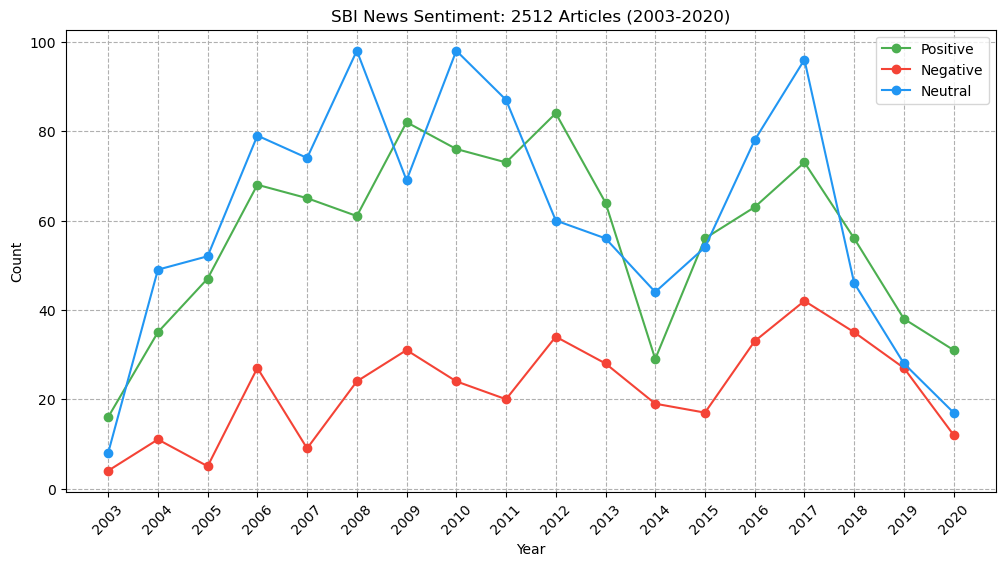

In [40]:
analyze_and_visualize_company_sentiment('SBI', news_df)

In [41]:
save_news_dataframe()

News DataFrame saved to Indian_FinancialNews_Updated.csv
